### *Import Requirements*

In [1]:
!pip install numpy matplotlib gymnasium

In [16]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import pickle
from collections import defaultdict
import random
from collections import deque
import torch
import torch.nn as nn
import torch.optim as optim

### *Defining the Environment Class*

In [17]:
class DroneDeliveryEnv(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, stochastic=False):
        super(DroneDeliveryEnv, self).__init__()

        self.grid_size = (6, 6)
        self.start_pos = [1, 1]  # Starting position
        self.package_pickup = [2, 4]  # Pickup location
        self.delivery_location = [6, 6]  # Delivery location
        self.no_fly_zones = {(2, 5), (3, 4), (5, 2), (6, 3)}  # Obstacles
        self.stochastic = stochastic

        # Actions: 0=Up, 1=Down, 2=Left, 3=Right, 4=Pickup, 5=Drop-off
        self.action_space = spaces.Discrete(6)
        self.observation_space = spaces.Tuple((
            spaces.Discrete(self.grid_size[0]),  # x-coordinate
            spaces.Discrete(self.grid_size[1]),  # y-coordinate
            spaces.Discrete(2)  # Carrying package (0 or 1)
        ))
        self.reset()

    def reset(self, seed=None, options=None):
        """Resets the environment to the initial state"""
        super().reset(seed=seed)
        self.position = self.start_pos[:]
        self.carrying_package = False
        self.steps = 0
        return self._get_observation(), {}

    def _get_observation(self):
        """Returns the current state as an observation"""
        return (self.position[0], self.position[1], int(self.carrying_package))

    def step(self, action, render_mode=False):
        """Executes one timestep in the environment"""
        reward = -1  # Step penalty
        terminated = False
        prev_position = self.position[:]  # Store previous position before movement
        prev_carrying = self.carrying_package

        if self.stochastic and np.random.rand() < 0.1:
            action = np.random.choice([0, 1, 2, 3])  # 10% probability of random movement

        new_position = self.position[:]

        # Movement actions
        if action == 0:  # Up
            new_position[0] -= 1
        elif action == 1:  # Down
            new_position[0] += 1
        elif action == 2:  # Left
            new_position[1] -= 1
        elif action == 3:  # Right
            new_position[1] += 1

        # Ensure the agent stays within the grid boundaries
        if 1 <= new_position[0] <= self.grid_size[0] and 1 <= new_position[1] <= self.grid_size[1]:
            self.position = new_position[:]

        # Check if the new position is in a no-fly zone
        if tuple(self.position) in self.no_fly_zones:
            self.position = prev_position  # Revert move
            reward = -100  # Large penalty for entering restricted areas
            terminated = True

        # Pickup action
        if action == 4:
            if self.position == self.package_pickup and not self.carrying_package:
                self.carrying_package = True
                reward = 50  # Reward for successful pickup
                #print(f" Picked up the package at {self.position}, carrying = {self.carrying_package}")
            else:
                reward -= 5  # Penalize unnecessary pickup attempts

        # Drop-off action
        elif action == 5:
            if self.position == self.delivery_location and self.carrying_package:
                self.carrying_package = False  # Package delivered
                reward = 100  # Successful delivery reward
                terminated = True
                #print(f" Package delivered at {self.position}, carrying = {self.carrying_package}")
            else:
                reward -= 10  # Penalize unnecessary drop-off attempts

        new_state = self._get_observation()

        self.steps += 1

        if render_mode:
            self.render()

        return new_state, reward, terminated, False, {}

    def render(self):
        """Renders the grid environment"""
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.set_xlim(0.5, 6.5)
        ax.set_ylim(0.5, 6.5)

        def add_image(image_path, position, zoom=0.6):
            img = plt.imread(image_path)
            imagebox = OffsetImage(img, zoom=zoom)
            centered_position = (position[1], 7 - position[0])  # Ensuring correct positioning
            ab = AnnotationBbox(imagebox, centered_position, frameon=False)
            ax.add_artist(ab)

        for nfz in self.no_fly_zones:
            add_image("images/no-fly.png", nfz, zoom=0.1)

        # Render pickup location if drone is not there
        if self.position != self.package_pickup and not self.carrying_package:
            add_image("images/pick-up.png", self.package_pickup, zoom=0.3)

        add_image("images/drop-off.png", self.delivery_location, zoom=0.1)

        if self.position == self.package_pickup and not self.carrying_package:
            add_image("images/at-pickup.png", self.position, zoom=0.1)
        elif self.carrying_package:
            add_image("images/carrying.png", self.position, zoom=0.2)
        else:
            add_image("images/drone.png", self.position, zoom=0.1)

        ax.set_xticks(np.arange(1, 7))
        ax.set_yticks(np.arange(1, 7))
        ax.set_xticklabels(np.arange(1, 7))
        ax.set_yticklabels(np.arange(6, 0, -1))

        ax.set_xticks(np.arange(0.5, 6.5, 1), minor=True)
        ax.set_yticks(np.arange(0.5, 6.5, 1), minor=True)
        ax.grid(which="minor", color='gray', linestyle='-', linewidth=0.5)

        plt.title(f"Drone Position: {self.position}, Carrying: {self.carrying_package}")
        plt.show()

In [18]:
print("CUDA available:", torch.cuda.is_available())
print("GPU name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")

CUDA available: False
GPU name: None


In [21]:
# Replay Buffer
class ReplayMemory:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, transition):
        self.buffer.append(transition)

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)


# Q-network for discrete state (x, y, carrying)
class DQN(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=128, output_dim=6):
        super(DQN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)  # Q-values for 6 actions
        )

    def forward(self, x):
        return self.net(x)


# DQN Agent
class DQNAgent:
    def __init__(self, env, memory_capacity=10000, batch_size=32,
                 gamma=0.99, lr=0.001, target_update=100,
                 epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=0.9995):
        self.env = env
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.batch_size = batch_size
        self.gamma = gamma
        self.lr = lr
        self.target_update = target_update
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay

        self.policy_net = DQN().to(self.device)
        self.target_net = DQN().to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.lr)
        self.memory = ReplayMemory(memory_capacity)
        self.steps_done = 0

    def select_action(self, state):
        if random.random() < self.epsilon:
            return self.env.action_space.sample()
        else:
            state = torch.tensor(state, dtype=torch.float32, device=self.device).unsqueeze(0)
            with torch.no_grad():
                q_values = self.policy_net(state)
            return q_values.argmax().item()

    def optimize_model(self):
        if len(self.memory) < self.batch_size:
            return

        batch = self.memory.sample(self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.tensor(states, dtype=torch.float32, device=self.device)
        actions = torch.tensor(actions, dtype=torch.int64, device=self.device).unsqueeze(1)
        rewards = torch.tensor(rewards, dtype=torch.float32, device=self.device).unsqueeze(1)
        next_states = torch.tensor(next_states, dtype=torch.float32, device=self.device)
        dones = torch.tensor(dones, dtype=torch.bool, device=self.device).unsqueeze(1)

        q_values = self.policy_net(states).gather(1, actions)

        with torch.no_grad():
            next_q_values = self.target_net(next_states).max(1)[0].unsqueeze(1)
            target_q_values = rewards + (self.gamma * next_q_values * (~dones))

        loss = nn.functional.mse_loss(q_values, target_q_values)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def train(self, num_episodes=1000, max_steps=50):
        rewards_per_episode = []

        for episode in range(num_episodes):
            state, _ = self.env.reset()
            state = np.array(state, dtype=np.float32) / np.array([6, 6, 1])
            total_reward = 0

            for t in range(max_steps):
                action = self.select_action(state)
                next_state, reward, done, _, _ = self.env.step(action)
                next_state = np.array(next_state, dtype=np.float32)

                self.memory.push((state, action, reward, next_state, done))
                state = next_state
                total_reward += reward

                self.optimize_model()

                if done:
                    break

            # Update target network
            if episode % self.target_update == 0:
                self.target_net.load_state_dict(self.policy_net.state_dict())

            self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)
            rewards_per_episode.append(total_reward)

            if episode % 100 == 0:
                print(f"Episode {episode}, Total reward: {total_reward}, Epsilon: {self.epsilon:.3f}")

        return rewards_per_episode

    def save_model(self, filename="dqn_model.pth"):
        torch.save(self.policy_net.state_dict(), filename)

    def load_model(self, filename="dqn_model.pth"):
        self.policy_net.load_state_dict(torch.load(filename))
        self.target_net.load_state_dict(self.policy_net.state_dict())

    def evaluate(self, episodes=5, max_steps=50):
        for ep in range(episodes):
            state, _ = self.env.reset()
            state = np.array(state, dtype=np.float32)
            total_reward = 0
            print(f"\nEpisode {ep+1}")

            for t in range(max_steps):
                action = self.select_action(state)
                next_state, reward, done, _, _ = self.env.step(action, render_mode=True)
                state = np.array(next_state, dtype=np.float32)
                total_reward += reward
                if done:
                    break

            print(f"Total reward: {total_reward}")

Episode 0, Total reward: -134, Epsilon: 1.000
Episode 100, Total reward: -110, Epsilon: 0.951
Episode 200, Total reward: -150, Epsilon: 0.904
Episode 300, Total reward: -218, Epsilon: 0.860
Episode 400, Total reward: -167, Epsilon: 0.818
Episode 500, Total reward: -127, Epsilon: 0.778
Episode 600, Total reward: -180, Epsilon: 0.740
Episode 700, Total reward: -220, Epsilon: 0.704
Episode 800, Total reward: -118, Epsilon: 0.670
Episode 900, Total reward: -166, Epsilon: 0.637
Episode 1000, Total reward: -141, Epsilon: 0.606
Episode 1100, Total reward: -129, Epsilon: 0.577
Episode 1200, Total reward: -131, Epsilon: 0.548
Episode 1300, Total reward: -142, Epsilon: 0.522
Episode 1400, Total reward: -49, Epsilon: 0.496
Episode 1500, Total reward: -59, Epsilon: 0.472
Episode 1600, Total reward: -24, Epsilon: 0.449
Episode 1700, Total reward: -39, Epsilon: 0.427
Episode 1800, Total reward: -95, Epsilon: 0.406
Episode 1900, Total reward: -54, Epsilon: 0.386
Episode 2000, Total reward: -108, Epsi

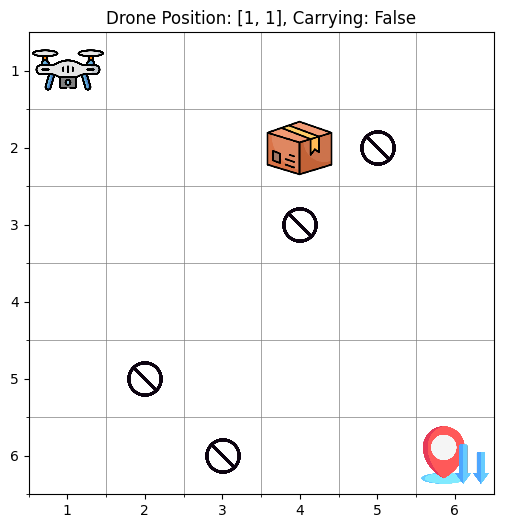

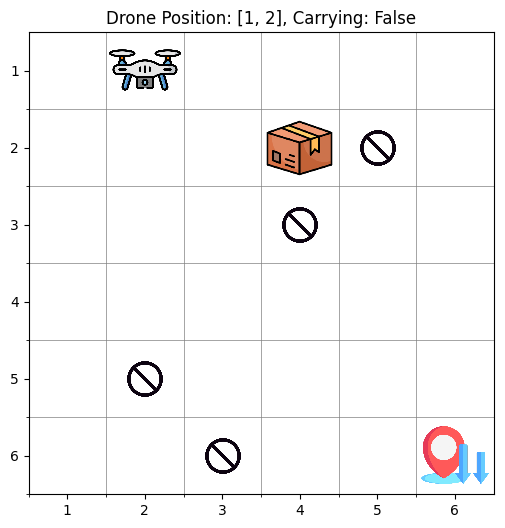

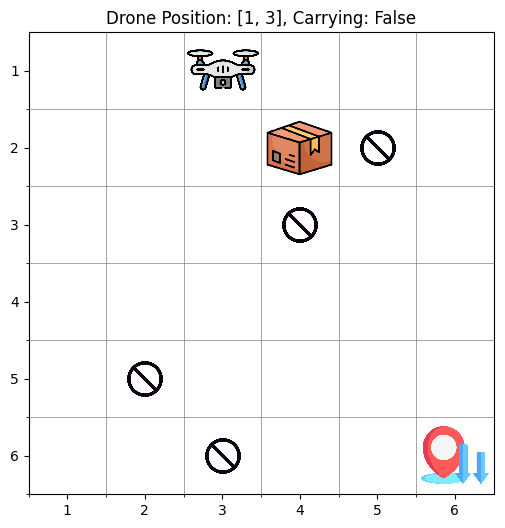

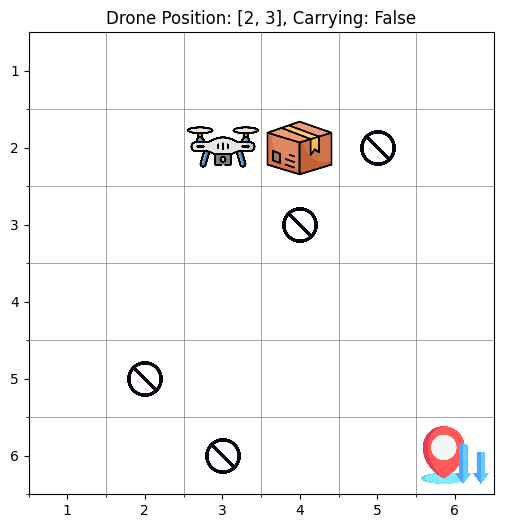

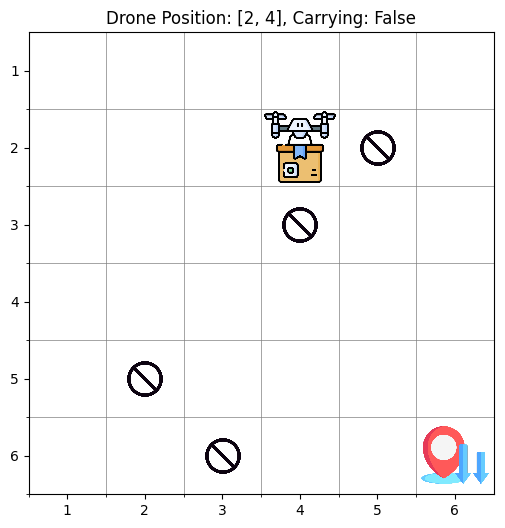

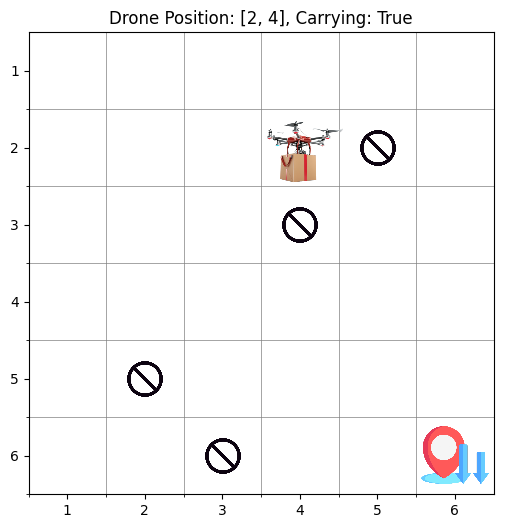

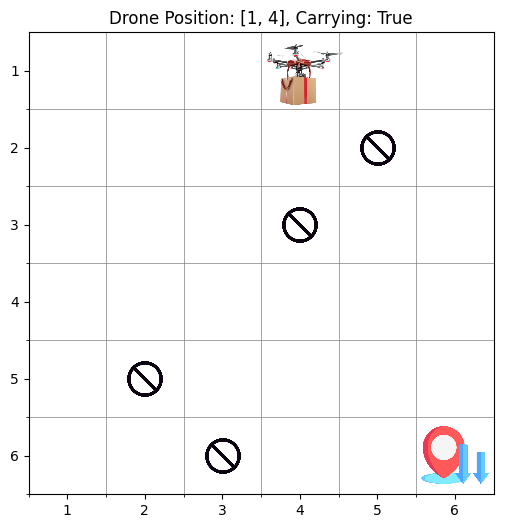

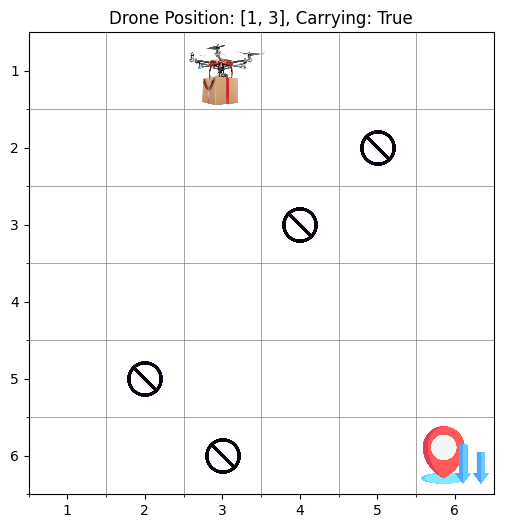

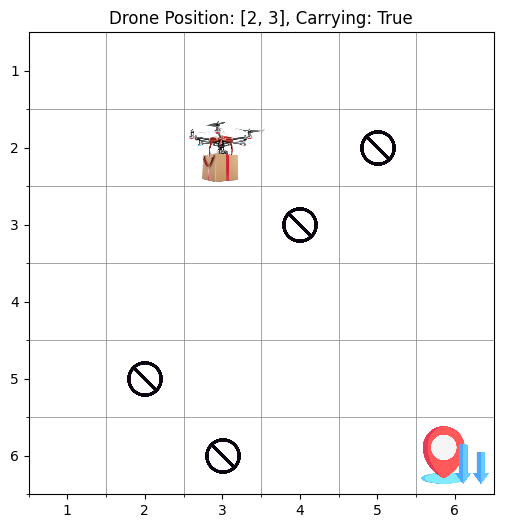

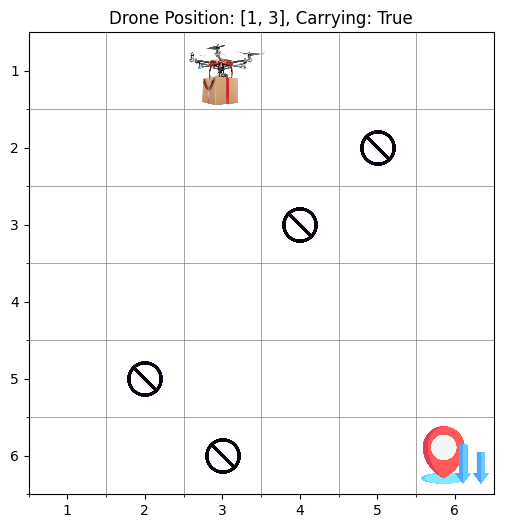

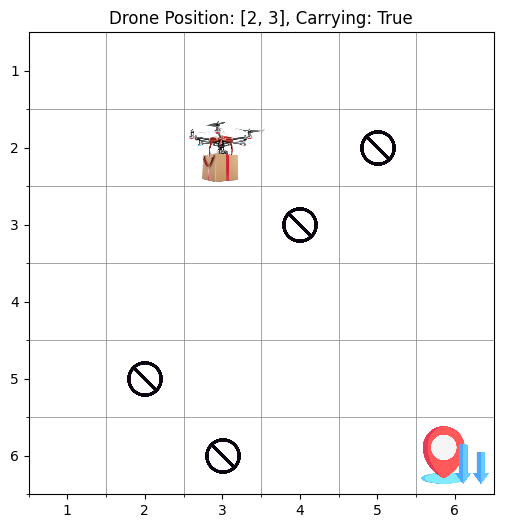

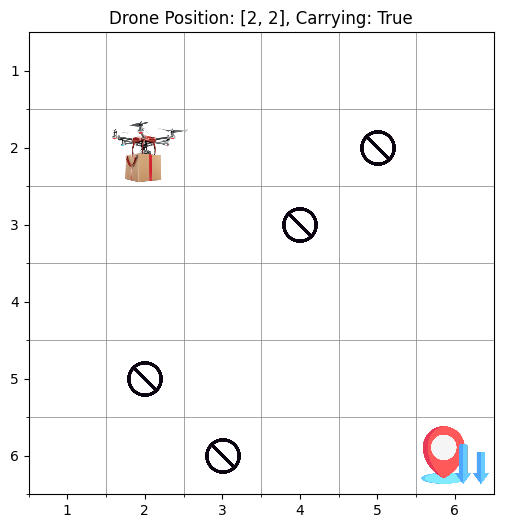

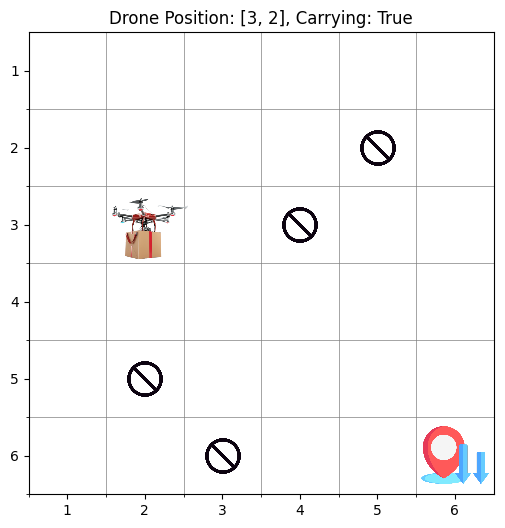

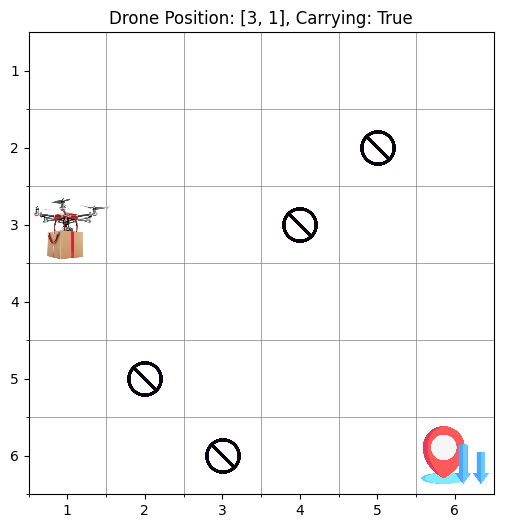

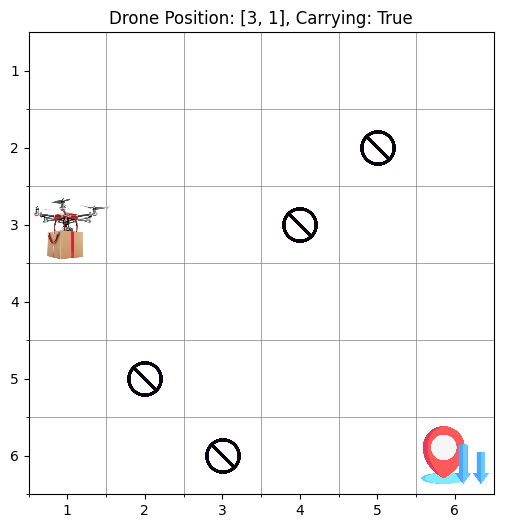

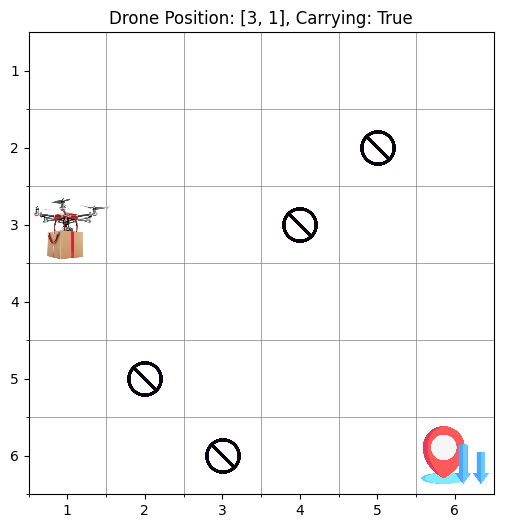

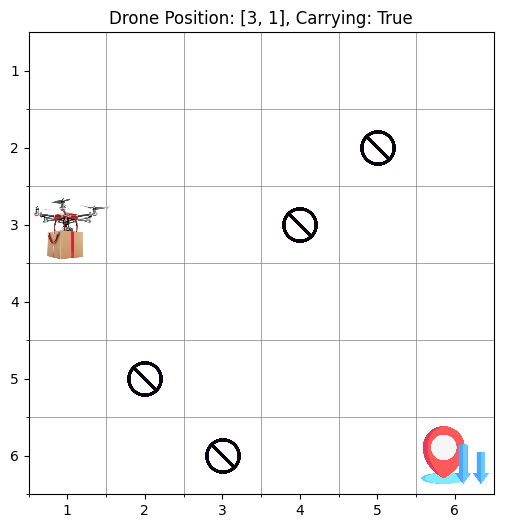

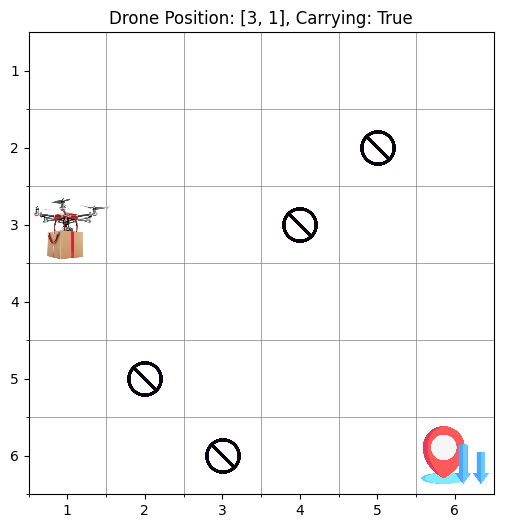

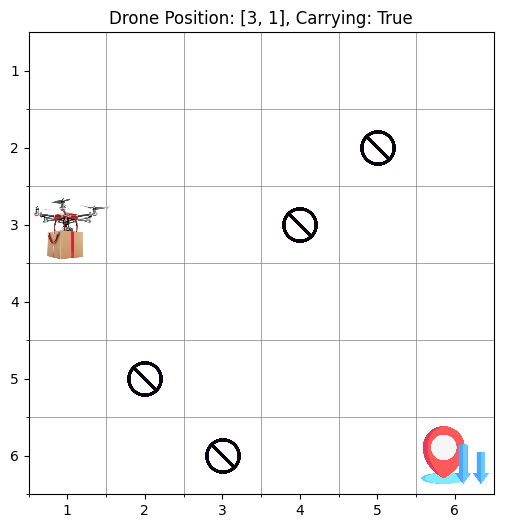

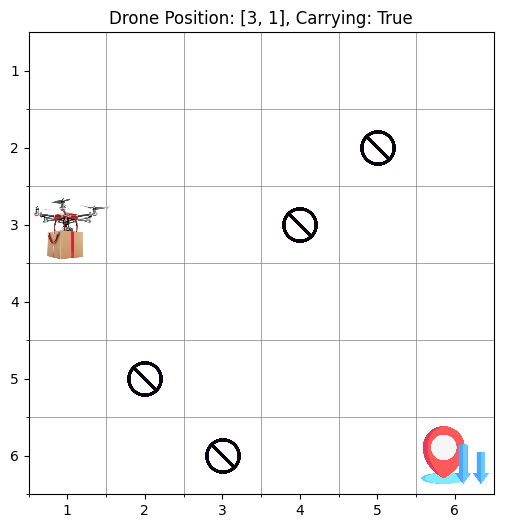

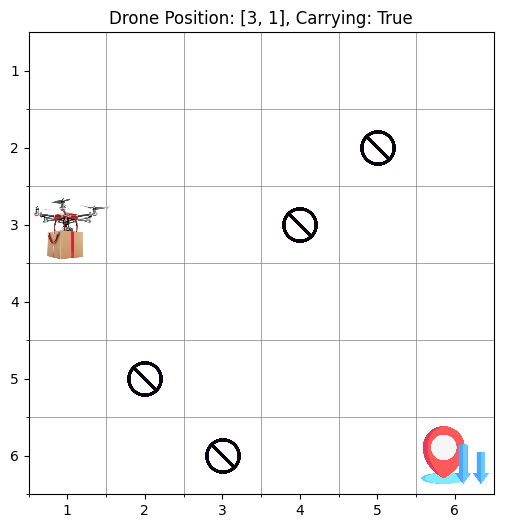

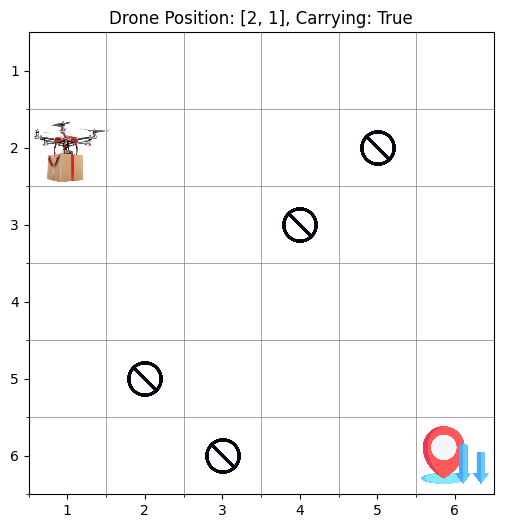

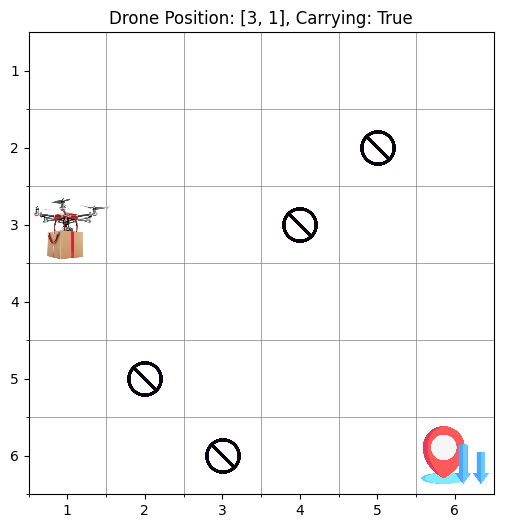

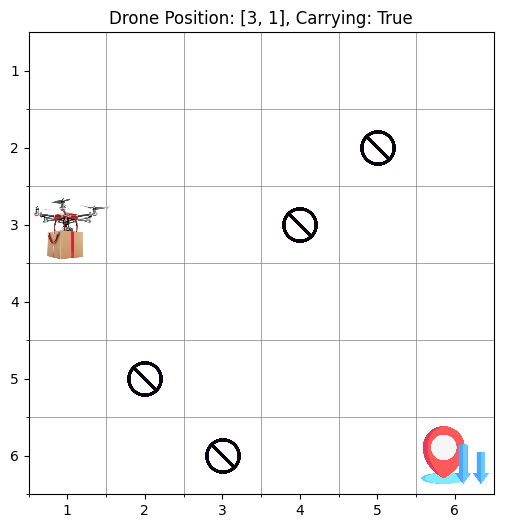

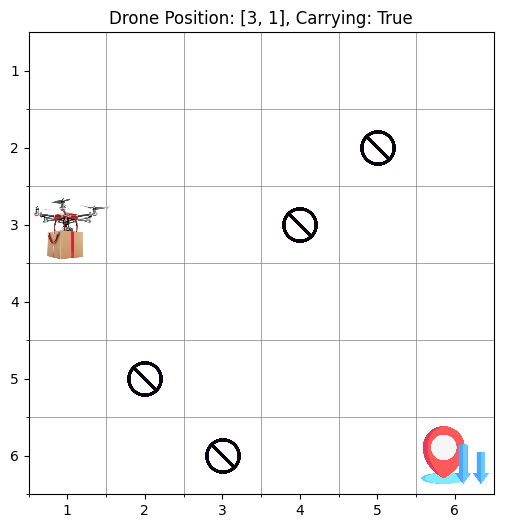

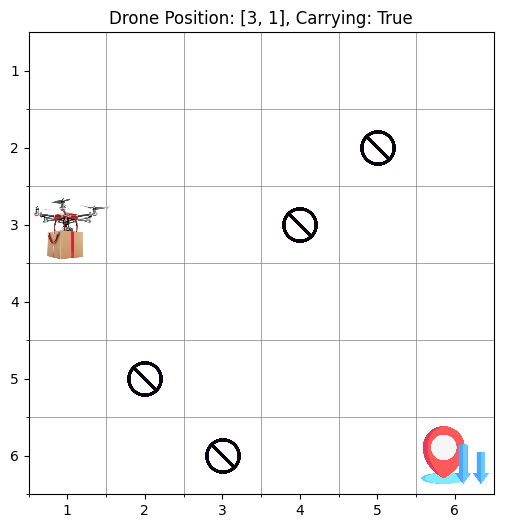

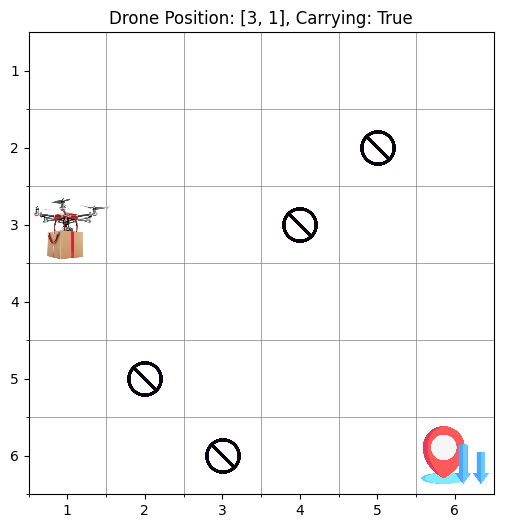

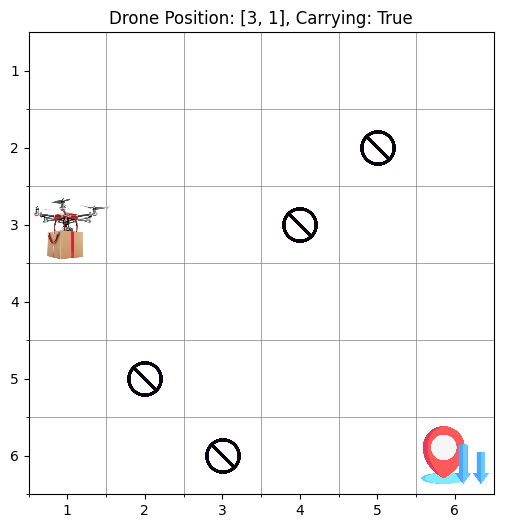

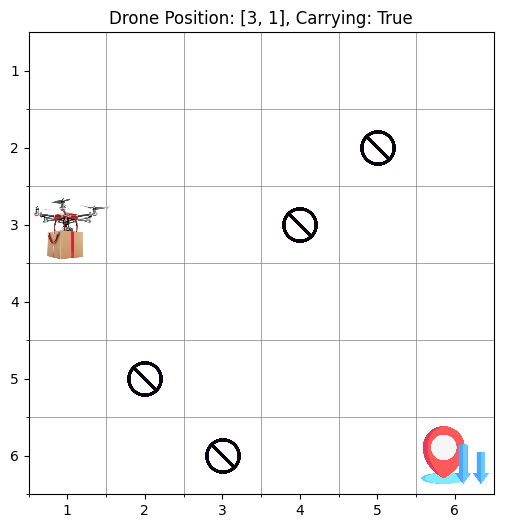

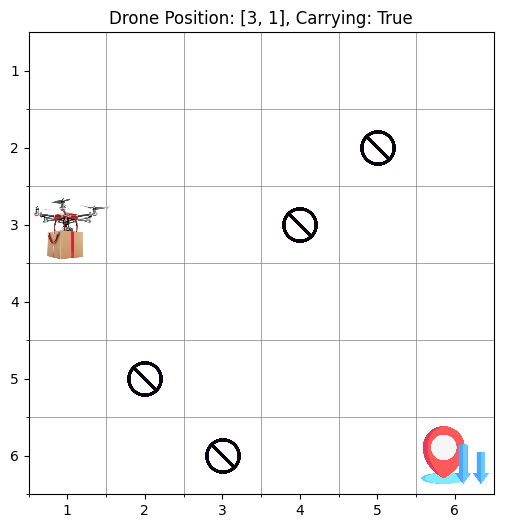

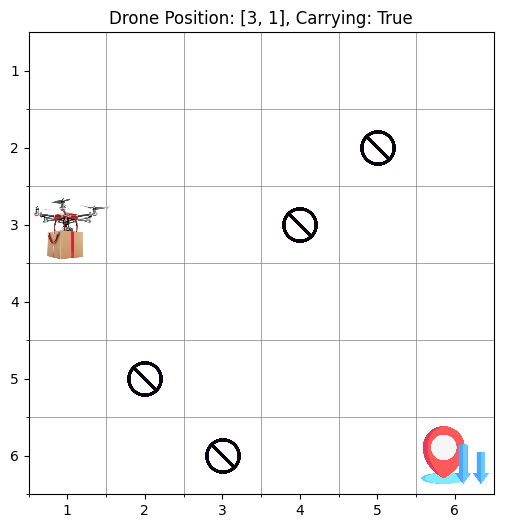

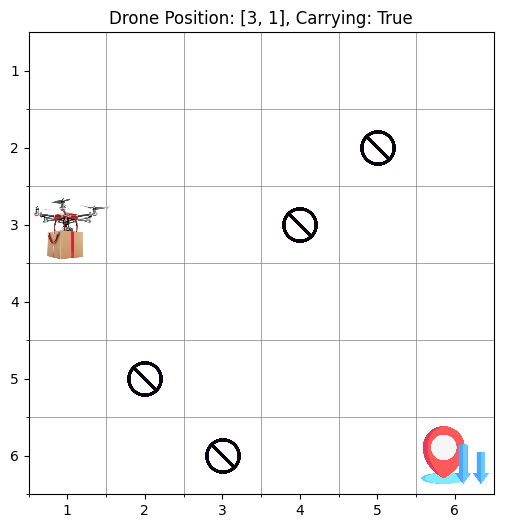

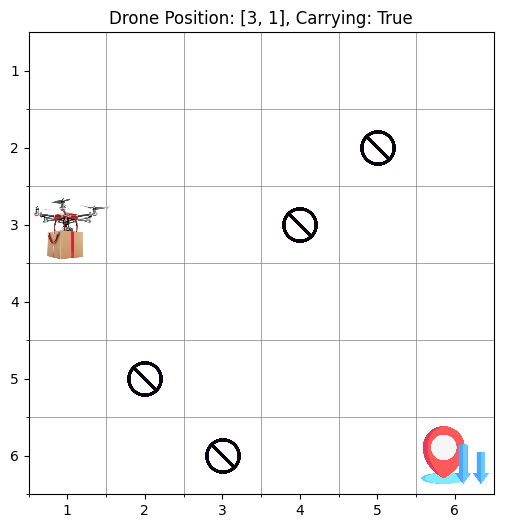

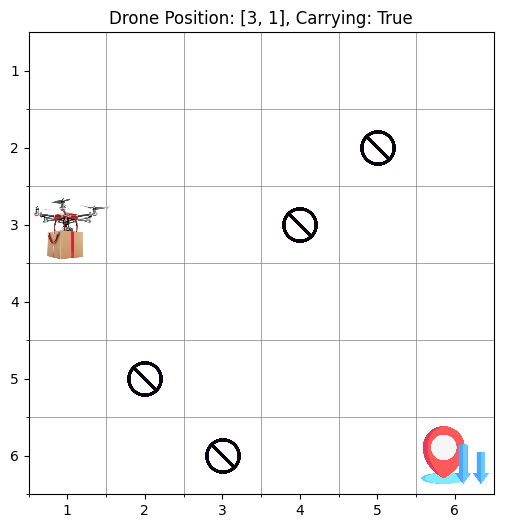

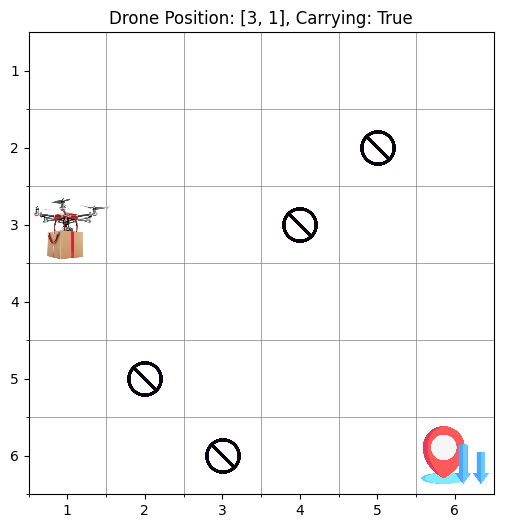

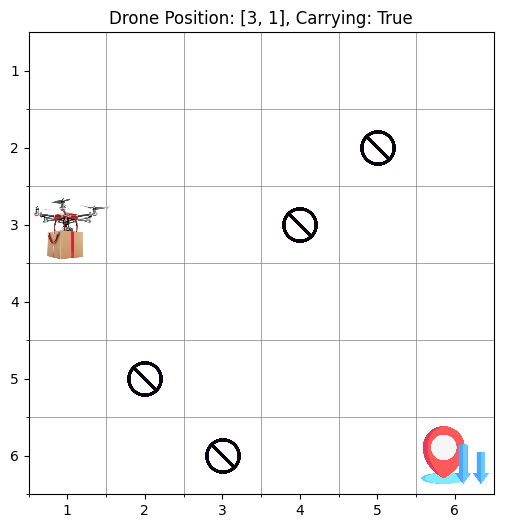

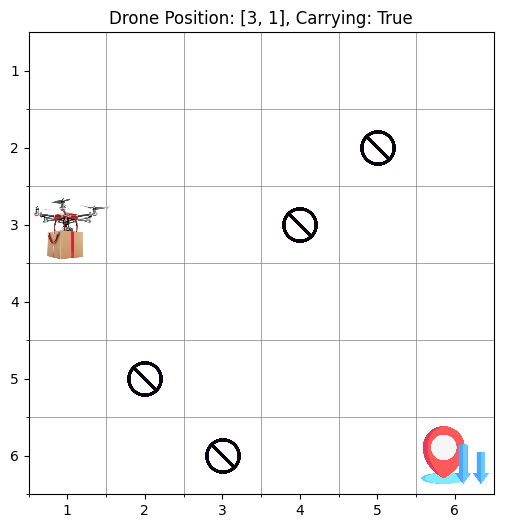

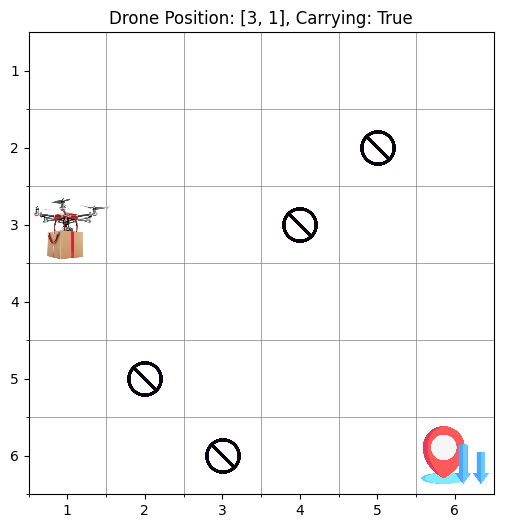

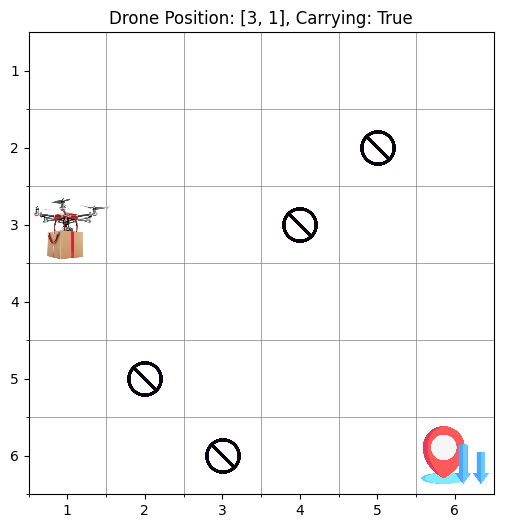

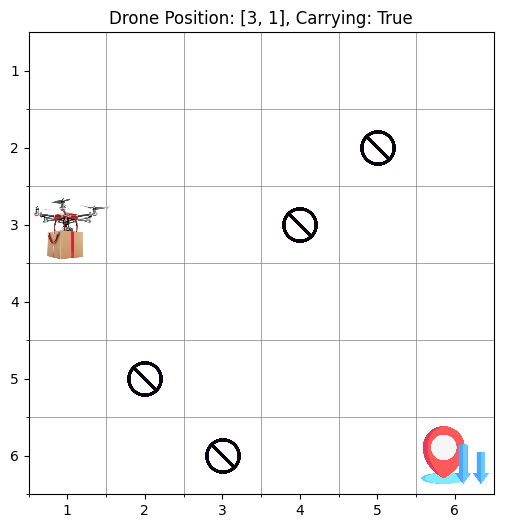

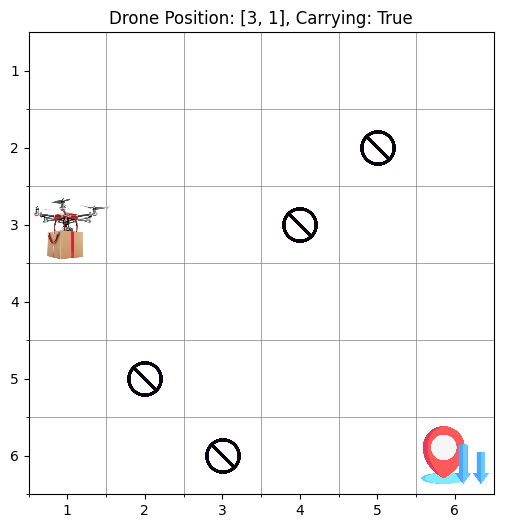

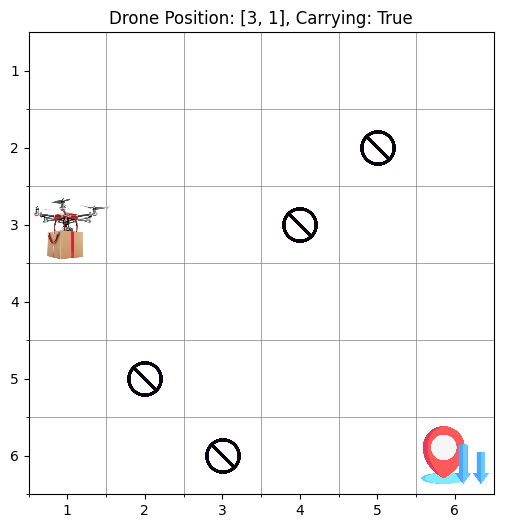

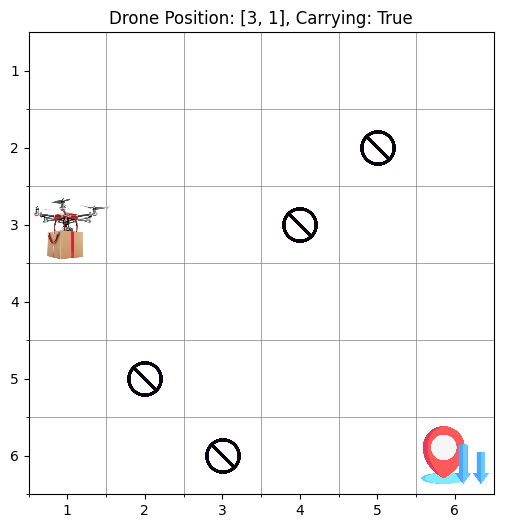

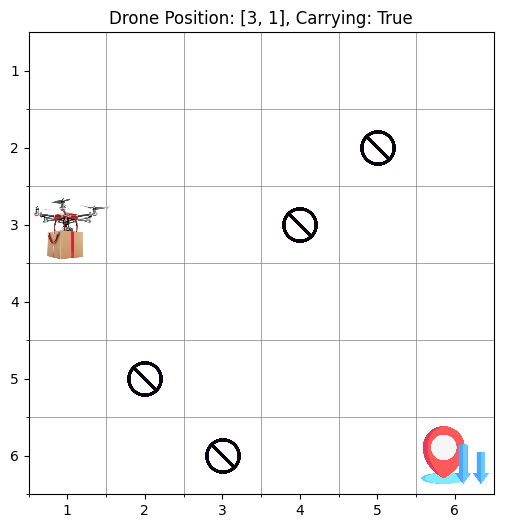

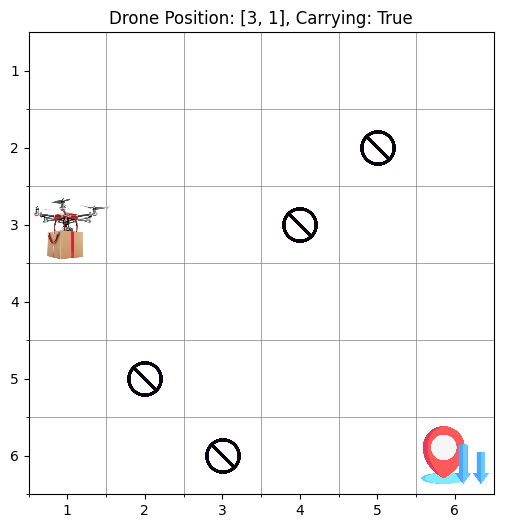

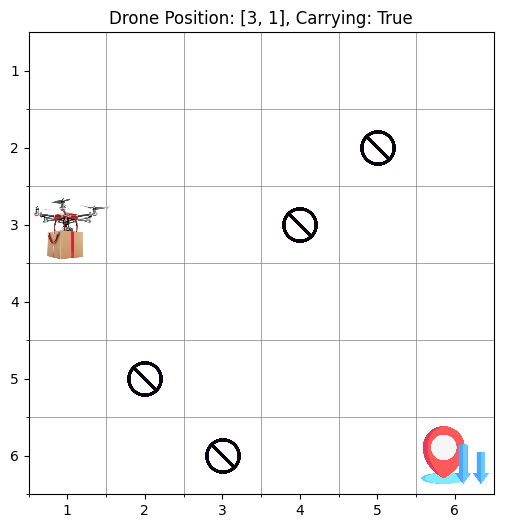

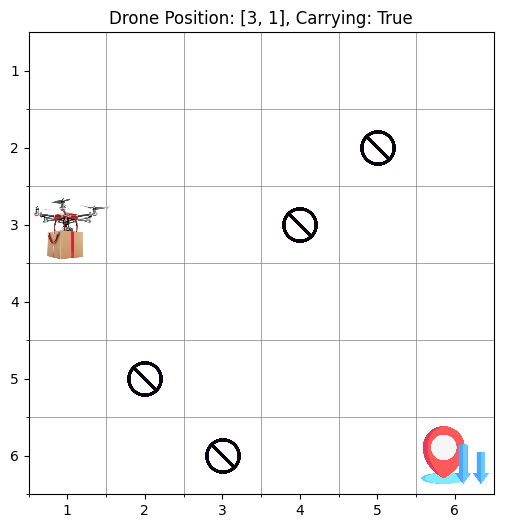

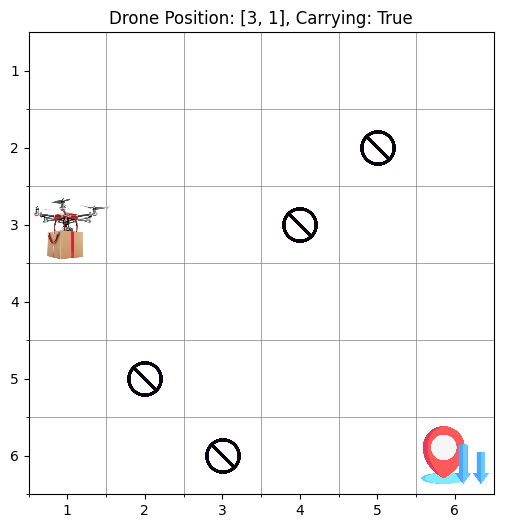

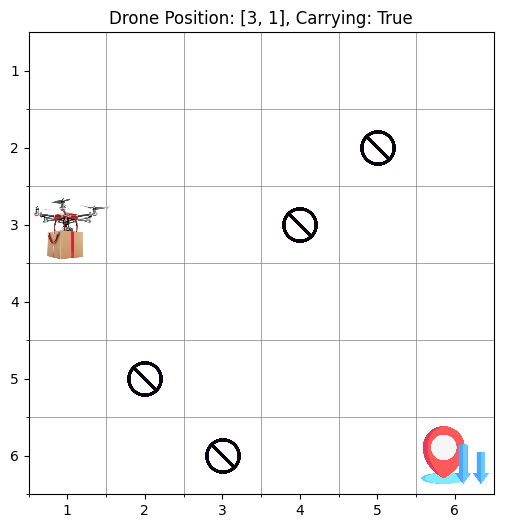

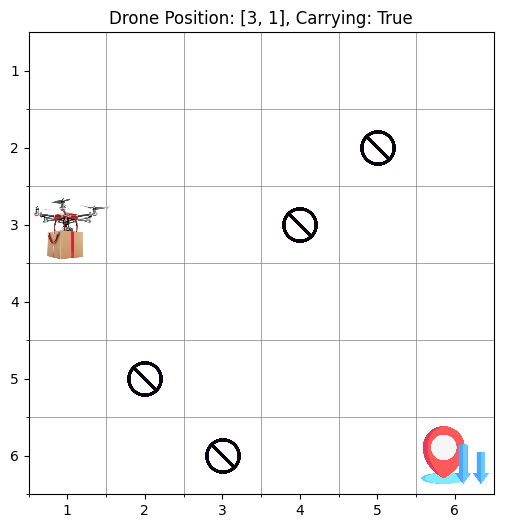

Total reward: -14


In [22]:
env = DroneDeliveryEnv(stochastic=False)
agent = DQNAgent(env)
rewards = agent.train(num_episodes=6000)
agent.save_model("dqn_drone_delivery.pth")

# Evaluate learned greedy policy
agent.evaluate(episodes=1)